# Google Summer of Code Midterm Submission
## Improving Renaissance Spanish OCR with CNN-RNN Hybrids and Weighted Learning
### Kate O'Reilly, Trinity College Dublin

Package Installation

In [21]:
%pip install PyMuPDF python-docx opencv-python scipy torch torchvision==0.2.1 pillow==8.3.1 natsort fitz tools frontend unidecode termcolor
# scikit-image

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import Modules

In [22]:
# Data Pre-processing
import fitz
import cv2
import csv
import os
from docx import Document
import torch
import string
import requests
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output as cls
from pathlib import Path

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



File Path Configuration

In [3]:
# Define paths for image folders and outputs
image_folders = {
    "Nobleza Virtuosa": {
        "pdf": Path("data/Padilla - Nobleza virtuosa_testExtract.pdf"),
        "input": Path("content/preprocessing/imgsUnProcessed"),
        "output": Path("content/preprocessing/imgsForAllPages"),
        "processed": Path("content/preprocessing/imgsProcessed"),
        "bounding_boxes": Path("content/preprocessing/BoundBoxApplied"),
        "bounding_boxes_sorted": Path("content/preprocessing/BoundBoxApplied_sorted"),
        "gt_docx": Path("data/Padilla - 1 Nobleza virtuosa_testTranscription.docx"),
        "text_file": Path("content/NoblezaVirtuosa_all_text.txt"),
        "split_text_output": Path("content/preprocessing/textSplitted_NoblezaVirtuosa"),
    },

    "Noble Perfecto": {
        "pdf": Path("data/Padilla - 2 Noble perfecto_Extract.pdf"),
        "input": Path("content/preprocessing/imgsUnProcessed2"),
        "output": Path("content/preprocessing/imgsForAllPages2"),
        "processed": Path("content/preprocessing/imgsProcessed2"),
        "bounding_boxes": Path("content/preprocessing/BoundBoxApplied2"),
        "bounding_boxes_sorted": Path("content/preprocessing/BoundBoxApplied_sorted2"),
        "gt_docx": Path("data/Padilla - 2 Noble perfecto_Transcription.docx"),
        "text_file": Path("content/NoblePerfecto_all_text.txt"),
        "split_text_output": Path("content/preprocessing/textSplitted_NoblePerfecto")
    }
}

Dataset Download

In [ ]:
PDF_DIR = Path("data")
FOLDER_ID ='195Bh7_Fz2NUWrfkL_t_GUJj4u3GlkjG8?fbclid=IwAR0F2UZl12H90Yk42J0l3rFx-w11fEfEv6AkbURNaXNM81Kf1-2He8VKFao'

gdown_command = f"gdown --folder https://drive.google.com/drive/folders/{FOLDER_ID} -O {PDF_DIR}"
print('Running:', gdown_command)
!{gdown_command}

print(f"Downloaded PDFs into NLPRenaissanceChallenge/data folder.")

In [3]:
import site
print(site.getsitepackages())


['c:\\Users\\katej\\AppData\\Local\\Programs\\Python\\Python39', 'c:\\Users\\katej\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages']


Apply Preprocessing Steps

**PDF → Page Images**  
Converts the original PDF into individual page `.png` images.

**Page Splitting**  
Detects and splits 2-page scans into single-page images based on width.

**Image Preprocessing (For Improved CRAFT Performance)**

Applies denoising, background removal, text enhancement, and contrast boosting, to each page.

**Combine the Datasets**


In [ ]:
from utils import run_full_preprocessing_pipeline

for name, paths in image_folders.items():
    run_full_preprocessing_pipeline(
        pdf_path=paths["pdf"],
        output_raw_folder=paths["input"],
        output_split_folder=paths["output"],
        output_preprocessed_folder=paths["processed"],
        source_suffix= name,
    )

Text Detection with CRAFT

In [8]:
#It generally takes about ~3-4 mins
!python CRAFT_Model/CRAFT/BoundBoxFunc/test.py --result_folder="data/pdf_samples"  --test_folder="data/processed_pages"  --trained_model="CRAFT_Model/CRAFT/BoundBoxFunc/weights/craft_mlt_25k.pth"

Loading weights from checkpoint (CRAFT_Model/CRAFT/BoundBoxFunc/weights/craft_mlt_25k.pth)
Test image 1/24: data/processed_pages\Ayala, Lorenzo de. Valladolid 1603_p007.png
Test image 2/24: data/processed_pages\Ayala, Lorenzo de. Valladolid 1603_p010.png
Test image 3/24: data/processed_pages\Ayala, Lorenzo de. Valladolid 1603_p012.png
Test image 4/24: data/processed_pages\Ayala, Lorenzo de. Valladolid 1603_p017.png
Test image 5/24: data/processed_pages\Burgos, Juan de. Valladolid 1500_p004.png
Test image 6/24: data/processed_pages\Burgos, Juan de. Valladolid 1500_p006.png
Test image 7/24: data/processed_pages\Burgos, Juan de. Valladolid 1500_p010.png
Test image 8/24: data/processed_pages\Burgos, Juan de. Valladolid 1500_p012.png
Test image 9/24: data/processed_pages\Burgos, Juan de. Valladolid 1500_p014.png
Test image 10/24: data/processed_pages\Cansoles, Fernando. Mallorca 1541_p003.png
Test image 11/24: data/processed_pages\Cansoles, Fernando. Mallorca 1541_p011.png
Test image 12/24:

In [ ]:
from utils import sort_bounding_boxes

sort_bounding_boxes(input_dir=image_folders["Nobleza Virtuosa"]["bounding_boxes"], output_dir=image_folders["Nobleza Virtuosa"]["bounding_boxes_sorted"],)
sort_bounding_boxes(input_dir=image_folders["Noble Perfecto"]["bounding_boxes"], output_dir=image_folders["Noble Perfecto"]["bounding_boxes_sorted"],)

In [3]:
from utils import sort_bounding_boxes

sort_bounding_boxes(input_dir="data/results", output_dir="output/craft/boxes_sorted")


Processing bounding boxes in: data\results
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-05_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-06_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-07_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-08_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-09_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-10_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-11_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-15_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-17_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-18_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1603-19_sorted.txt
Sorted boxes written: res_Ayala, Lorenzo de. Valladolid 1

Extract Transcriptions

In [ ]:
import importlib
from utils import extract_ground_truth_for_dataset

extract_ground_truth_for_dataset(
    docx_file="data/Padilla - 1 Nobleza virtuosa_testTranscription.docx",
    output_path="content/NoblezaVirtuosa_all_text.txt"
)
extract_ground_truth_for_dataset(
    docx_file="data/Padilla - 2 Noble perfecto_Transcription.docx",
    output_path="content/NoblePerfecto_all_text.txt"
)

Split Transcription by Page

In [ ]:
from utils import process_textfiles
import os

for name, paths in image_folders.items():
    textfile = paths["text_file"]
    sorted_BoundBox_folder = paths["bounding_boxes_sorted"]
    output_folder = paths["split_text_output"]
    os.makedirs(output_folder, exist_ok=True)
    print(f"Splitting text for {name}...")
    process_textfiles(textfile, sorted_BoundBox_folder, output_folder)
    print(f"Text splitting complete for {name}! Output: {output_folder}")


Extract and Save Boxes with Labels

In [ ]:
from utils import apply_extraction_to_folder_for_train

for name, paths in image_folders.items():
    apply_extraction_to_folder_for_train(
        image_folder=paths["processed"],
        bounding_box_folder=paths["bounding_boxes_sorted"],
        text_folder=paths["split_text_output"],
        output_folder="content/train_data/",
    )

In [ ]:
from utils import apply_extraction_to_folder_for_test

for name, paths in image_folders.items():
    apply_extraction_to_folder_for_test(
        image_folder=paths["processed"],
        bounding_box_folder=paths["bounding_boxes_sorted"],
        output_folder="content/test_data/",
    )

In [15]:

def extract_words_from_images(image_folder: str, box_folder: str, output_folder: str, box_format='_sorted.txt'):
    """
    Extracts word regions from images based on bounding box coordinates in .txt files.
    
    Args:
        image_folder (str): Path to folder containing images.
        box_folder (str): Path to folder containing box coordinate files.
        output_folder (str): Path to folder to save cropped word images.
        box_format (str): File extension of box files (default is 'txt').
    """
    os.makedirs(output_folder, exist_ok=True)

    image_paths = sorted(Path(image_folder).glob("*.png"))
    for img_path in image_paths:
        img_name = img_path.stem
        box_path = Path(box_folder) / f"res_{img_name}{box_format}"
        if not box_path.exists():
            print(f"⚠️ Box file not found for image: {img_path.name}")
            continue

        # Read image
        image = cv2.imread(str(img_path))
        if image is None:
            print(f"⚠️ Could not read image: {img_path.name}")
            continue

        # Read box coordinates
        try:
            with open(box_path, 'r', encoding='utf-8') as f:
                lines = f.read().strip().splitlines()
            for i, line in enumerate(lines):
                coords = list(map(int, line.strip().replace(';', ' ').replace(',', ' ').split()))
                if len(coords) == 4:
                    x, y, w, h = coords
                elif len(coords) == 8:
                    xs = coords[0::2]
                    ys = coords[1::2]
                    x, y, w, h = min(xs), min(ys), max(xs) - min(xs), max(ys) - min(ys)
                else:
                    print(f"⚠️ Invalid box format in {box_path.name} line {i + 1}: {line}")
                    continue
                
                word_crop = image[y:y+h, x:x+w]
                output_path = Path(output_folder) / f"{img_name}_word_{i}.png"
                cv2.imwrite(str(output_path), word_crop)
        except Exception as e:
            print(f"❌ Failed to process {box_path.name}: {e}")

    print("✅ Word extraction completed.")

# Displaying a few extracted word images (preview)
def preview_extracted_words(folder: str, n: int = 8):
    word_paths = sorted(Path(folder).glob("*.png"))[:n]
    plt.figure(figsize=(15, 2))
    for i, path in enumerate(word_paths):
        img = cv2.imread(str(path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(path.name, fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [16]:
extract_words_from_images("data/processed_data", "output/craft/boxes_sorted", "output/craft/words_extracted")

⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 2: ;
⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 4: ;
⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 7: ;
⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 9: ;
⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 12: ;
⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 15: ;
⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 19: ;
⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 23: ;
⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 25: ;
⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 27: ;
⚠️ Invalid box format in res_Ayala, Lorenzo de. Valladolid 1603-01_sorted.txt line 29: ;
⚠️ Invalid box format in 

Pad and Resize Images

In [ ]:
from utils import pad_and_resize_images

pad_and_resize_images("content/train_data")
pad_and_resize_images("content/test_data")


Create CSV with Filename and Identity

In [4]:
from utils import create_csv_from_folder

create_csv_from_folder("data/inverted", "train.csv")
create_csv_from_folder("data/test_data/", "test.csv")

CSV created at train.csv with 4126 entries.
CSV created at test.csv with 326 entries.


Create Validation CSV

In [6]:
from sklearn.model_selection import train_test_split

# Load full CSV
full_df = pd.read_csv("train.csv")

# Split (e.g., 90% train, 10% val)
train_df, val_df = train_test_split(full_df, test_size=0.1, random_state=42, shuffle=True)

# Save new CSVs
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

print(f"[INFO] Training set: {len(train_df)} samples")
print(f"[INFO] Validation set: {len(val_df)} samples")


[INFO] Training set: 3341 samples
[INFO] Validation set: 372 samples


Model Configurations

In [23]:
IMG_HEIGHT = 32
IMG_WIDTH = 128
BATCH_SIZE = 32
HIDDEN_SIZE = 256
NUM_EPOCHS = 15

In [24]:
import pandas as pd

# Load data
train_df = pd.read_csv("csv/train.csv")
val_df = pd.read_csv("csv/val.csv")

# Build CHARSET from all data
all_text = ''.join(train_df['IDENTITY'].astype(str)) + ''.join(val_df['IDENTITY'].astype(str))
CHARSET = ''.join(sorted(set(all_text)))

print(f"[INFO] Character Set ({len(CHARSET)}): {repr(CHARSET)}")

# Build mappings
char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARSET)}  # 0 is CTC blank
idx_to_char = {idx + 1: char for idx, char in enumerate(CHARSET)}
idx_to_char[0] = ''  # blank token for CTC


[INFO] Character Set (50): ' ABCDEFGHIKLMNOPQRSTUVXYZabcdefghijlmnopqrstuvxyzñ'


In [7]:
with open("charset.txt", "r", encoding="utf-8") as f:
    CHARSET = f.read()

char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARSET)}  # CTC blank = 0
idx_to_char = {idx + 1: char for idx, char in enumerate(CHARSET)}
idx_to_char[0] = ''  # blank


In [8]:
def find_unknown_chars(df, charset):
    all_text = ''.join(df['IDENTITY'].dropna().astype(str))
    return sorted(set(all_text) - set(charset))

print("Unknowns in train:", find_unknown_chars(train_df, CHARSET))
print("Unknowns in val:", find_unknown_chars(val_df, CHARSET))


Unknowns in train: []
Unknowns in val: []


Dataset Configurations

In [25]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
from pathlib import Path
from urllib.parse import unquote
import unicodedata
import pandas as pd

def normalize_path(path):
    path = Path(str(path))
    try:
        path = unquote(str(path).encode("latin1").decode("utf-8"))
    except Exception:
        path = str(path)
    return unicodedata.normalize("NFC", path)

class OCRDataset(Dataset):
    def __init__(self, csv_path, transform=None, char_to_idx=None):
        self.df = pd.read_csv(csv_path, quotechar='"')
        self.df["IDENTITY"] = self.df["IDENTITY"].astype(str).str.strip()
        self.df = self.df[
            self.df["IDENTITY"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0 and x.lower() != 'nan')
        ]

        self.transform = transform
        self.char_to_idx = char_to_idx  # <-- pass externally!

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = normalize_path(row['FILENAME'])
        label_str = unicodedata.normalize('NFC', str(row['IDENTITY']).strip())

        try:
            img = Image.open(img_path).convert("L")
        except Exception as e:
            raise FileNotFoundError(f"Could not open image: {img_path}\n{e}")

        img = img.resize((128, 32))
        img = np.array(img).astype(np.uint8)
        img = Image.fromarray(img, mode='L')

        if self.transform:
            img = self.transform(img)

        if self.char_to_idx is None:
            raise ValueError("char_to_idx mapping must be provided to OCRDataset.")
        label = [self.char_to_idx[c] for c in label_str if c in self.char_to_idx]
        return img, torch.tensor(label, dtype=torch.long), len(label), label_str


Collate Function

In [26]:
import torchvision.transforms as transforms

def collate_fn(batch):
    images, labels, label_lengths, label_strs = zip(*batch)

    # Ensure all images are tensors
    tensor_images = []
    for img in images:
        if not isinstance(img, torch.Tensor):
            img = transforms.ToTensor()(img)
        tensor_images.append(img)

    images = torch.stack(tensor_images)
    labels_concat = torch.cat(labels)
    label_lengths = torch.tensor(label_lengths, dtype=torch.long)

    return images, labels_concat, label_lengths, label_strs


CRNN Model

In [27]:
class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0
        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),                    # H: 32 → 16
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),                   # H: 16 → 8
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d((2, 2), (2, 1), (0, 1)), # H: 8 → 4
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)),
            nn.AdaptiveAvgPool2d((1, None))                                             
        )

        self.rnn1 = nn.LSTM(512, nh, bidirectional=True)
        self.rnn2 = nn.LSTM(nh * 2, nh, bidirectional=True)
        
        self.embedding = nn.Linear(nh * 2, nclass)

    def forward(self, x):
        conv = self.cnn(x)

        b, c, h, w = conv.size()
        assert h == 1
        conv = conv.squeeze(2).permute(2, 0, 1)  # [w, b, c]
        rnn_out, _ = self.rnn1(conv)
        rnn_out, _ = self.rnn2(rnn_out)
        output = self.embedding(rnn_out)
        return output

Greedy Decoder

In [28]:
def decode(output):
    out = output.softmax(2)
    _, max_idx = out.max(2)
    max_idx = max_idx.transpose(1, 0)

    texts = []
    for pred in max_idx:
        pred = pred.cpu().numpy()
        chars = []
        prev = -1
        for p in pred:
            if p != prev and p != 0:
                chars.append(idx_to_char[p])
            prev = p
        texts.append(''.join(chars))
    return texts

Beam Decoder

In [29]:
from collections import defaultdict
import torch

def ctc_beam_search_decoder(probs, charset, beam_width=10, blank_index=0):
    T, C = probs.shape  # probs is [T, C] numpy array
    beams = [("", 1.0)]  # list of (sequence, score)

    for t in range(T):
        new_beams = defaultdict(float)
        for prefix, score in beams:
            for c in range(C):
                p = probs[t, c]
                char = '' if c == blank_index else charset[c - 1]

                # Extend current beam
                new_seq = prefix if char == '' or (len(prefix) > 0 and char == prefix[-1]) else prefix + char
                new_beams[new_seq] += score * p
        # Keep top beam_width beams
        beams = sorted(new_beams.items(), key=lambda x: x[1], reverse=True)[:beam_width]
    return beams[0][0]  # best sequence



Beam Search with Lexicon

In [30]:
from collections import defaultdict
from unidecode import unidecode
from difflib import get_close_matches


def correct_with_lexicon(seq, lexicon, fuzzy=True):
    seq_norm = unidecode(seq.lower())

    if seq_norm in lexicon:
        return seq  # already valid

    if fuzzy:
        matches = get_close_matches(seq_norm, lexicon, n=1, cutoff=0.9)
        if matches:
            return matches[0]  # corrected to best match

    return seq  # fallback


def ctc_beam_search_decoder_with_lexicon(
    probs, charset, lexicon=None, beam_width=5, blank_index=0, fuzzy=True
):
    T, C = probs.shape
    beams = [("", 1.0)]
    for t in range(T):
        new_beams = defaultdict(float)
        for prefix, score in beams:
            for c in range(C):
                p = probs[t, c]
                char = '' if c == blank_index else charset[c - 1]
                new_seq = prefix if char == '' or (len(prefix) > 0 and char == prefix[-1]) else prefix + char
                new_beams[new_seq] += score * p
        beams = sorted(new_beams.items(), key=lambda x: x[1], reverse=True)[:beam_width]

    # No lexicon? Return best beam
    if not lexicon:
        return beams[0][0]

    # Normalize lexicon
    norm_lexicon = {unidecode(w.lower()) for w in lexicon}

    for seq, score in beams:
        seq_norm = unidecode(seq.lower())
        if seq_norm in norm_lexicon:
            return seq  # original (non-normalized) version

    # Try fuzzy match fallback
    if fuzzy:
        for seq, score in beams:
            seq_norm = unidecode(seq.lower())
            matches = get_close_matches(seq_norm, norm_lexicon, n=1, cutoff=0.9)
            if matches:
                return matches[0]  # Return matched lexicon word


    return beams[0][0]  # fallback


Training Utilities

In [31]:
def save_checkpoint(model, optimizer, epoch, path='crnn_checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

def load_checkpoint(model, optimizer, path='crnn_checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


Load Data

In [32]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = OCRDataset("csv/train.csv", transform=transform, char_to_idx=char_to_idx)
val_dataset = OCRDataset("csv/val.csv", transform=transform, char_to_idx=char_to_idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Training Loop

In [28]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

early_stopper = EarlyStopping(patience=5)
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels_concat, label_lengths, _ in train_loader:
        images = images.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)

        outputs = model(images)
        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)

        loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels_concat, label_lengths, _ in val_loader:
            images = images.to(DEVICE)
            labels_concat = labels_concat.to(DEVICE)
            outputs = model(images)
            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)
            loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_checkpoint(model, optimizer, epoch, path='best_model.pth')
        print("Saved best model.")

    if early_stopper.step(avg_val_loss):
        print("Early stopping triggered.")
        break


Epoch 1, Train Loss: 3.9138, Val Loss: 3.2353
Saved best model.
Epoch 2, Train Loss: 3.1395, Val Loss: 3.2048
Saved best model.
Epoch 3, Train Loss: 3.0134, Val Loss: 3.0001
Saved best model.
Epoch 4, Train Loss: 2.7013, Val Loss: 3.1786
Epoch 5, Train Loss: 1.8458, Val Loss: 1.3767
Saved best model.
Epoch 6, Train Loss: 1.0723, Val Loss: 0.8431
Saved best model.
Epoch 7, Train Loss: 0.7236, Val Loss: 0.7738
Saved best model.
Epoch 8, Train Loss: 0.5770, Val Loss: 0.5300
Saved best model.
Epoch 9, Train Loss: 0.4827, Val Loss: 0.4999
Saved best model.


: 

Further Train

In [18]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)


In [19]:
import torch

checkpoint = torch.load("best_model.pth", map_location=DEVICE)

# Load model weights (skip if shape mismatch on output layer)
model_state = model.state_dict()
state_dict = checkpoint['model_state_dict']
for key in list(state_dict.keys()):
    if key in model_state and state_dict[key].shape != model_state[key].shape:
        print(f"Skipping {key} due to shape mismatch: {state_dict[key].shape} vs {model_state[key].shape}")
        del state_dict[key]
model.load_state_dict(state_dict, strict=False)

# Load optimizer state (optional)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
if "optimizer_state_dict" in checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Resume from epoch if saved
start_epoch = checkpoint.get("epoch", 0) + 1


In [20]:
criterion = torch.nn.CTCLoss(blank=0, zero_infinity=True)
early_stopper = EarlyStopping(patience=5)
NUM_EPOCHS =6

for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    model.train()
    train_loss = 0.0

    for images, labels_concat, label_lengths, _ in train_loader:
        images = images.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)

        outputs = model(images)
        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)

        loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels_concat, label_lengths, _ in val_loader:
            images = images.to(DEVICE)
            labels_concat = labels_concat.to(DEVICE)

            outputs = model(images)
            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)
            loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < early_stopper.best_loss:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'best_model_finetuned.pth')
        print("Saved improved model.")

    if early_stopper.step(avg_val_loss):
        print(" Early stopping triggered.")
        break


Epoch 9, Train Loss: 0.4287, Val Loss: 0.4573
Saved improved model.
Epoch 10, Train Loss: 0.3856, Val Loss: 0.4869
Epoch 11, Train Loss: 0.3603, Val Loss: 0.4049
Saved improved model.
Epoch 12, Train Loss: 0.3270, Val Loss: 0.4495
Epoch 13, Train Loss: 0.3061, Val Loss: 0.4116
Epoch 14, Train Loss: 0.2789, Val Loss: 0.4250


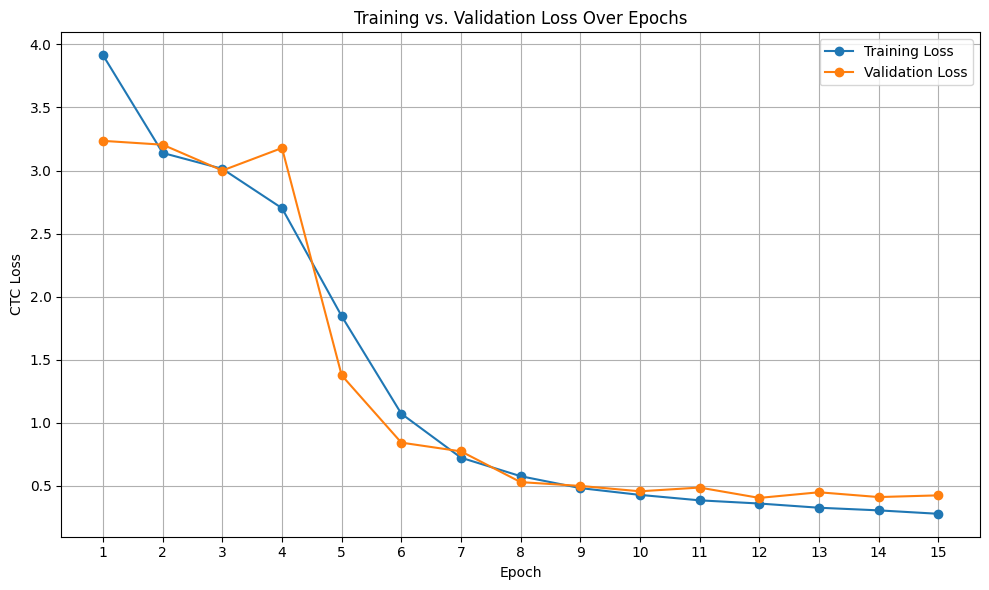

In [21]:
import matplotlib.pyplot as plt

# Manually extracted training and validation losses
train_losses = [
    3.9138, 3.1395, 3.0134, 2.7013, 1.8458, 1.0723,
    0.7236, 0.5770, 0.4827, 0.4287, 0.3856, 0.3603,
    0.3270, 0.3061, 0.2789
]

val_losses = [
    3.2353, 3.2048, 3.0001, 3.1786, 1.3767, 0.8431,
    0.7738, 0.5300, 0.4999, 0.4573, 0.4869, 0.4049,
    0.4495, 0.4116, 0.4250
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('CTC Loss')
plt.xticks(range(len(train_losses)), range(1, len(train_losses) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Visual Evaluation

c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance\venv\lib\site-packages\torchvision\transforms\functional.py:70: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


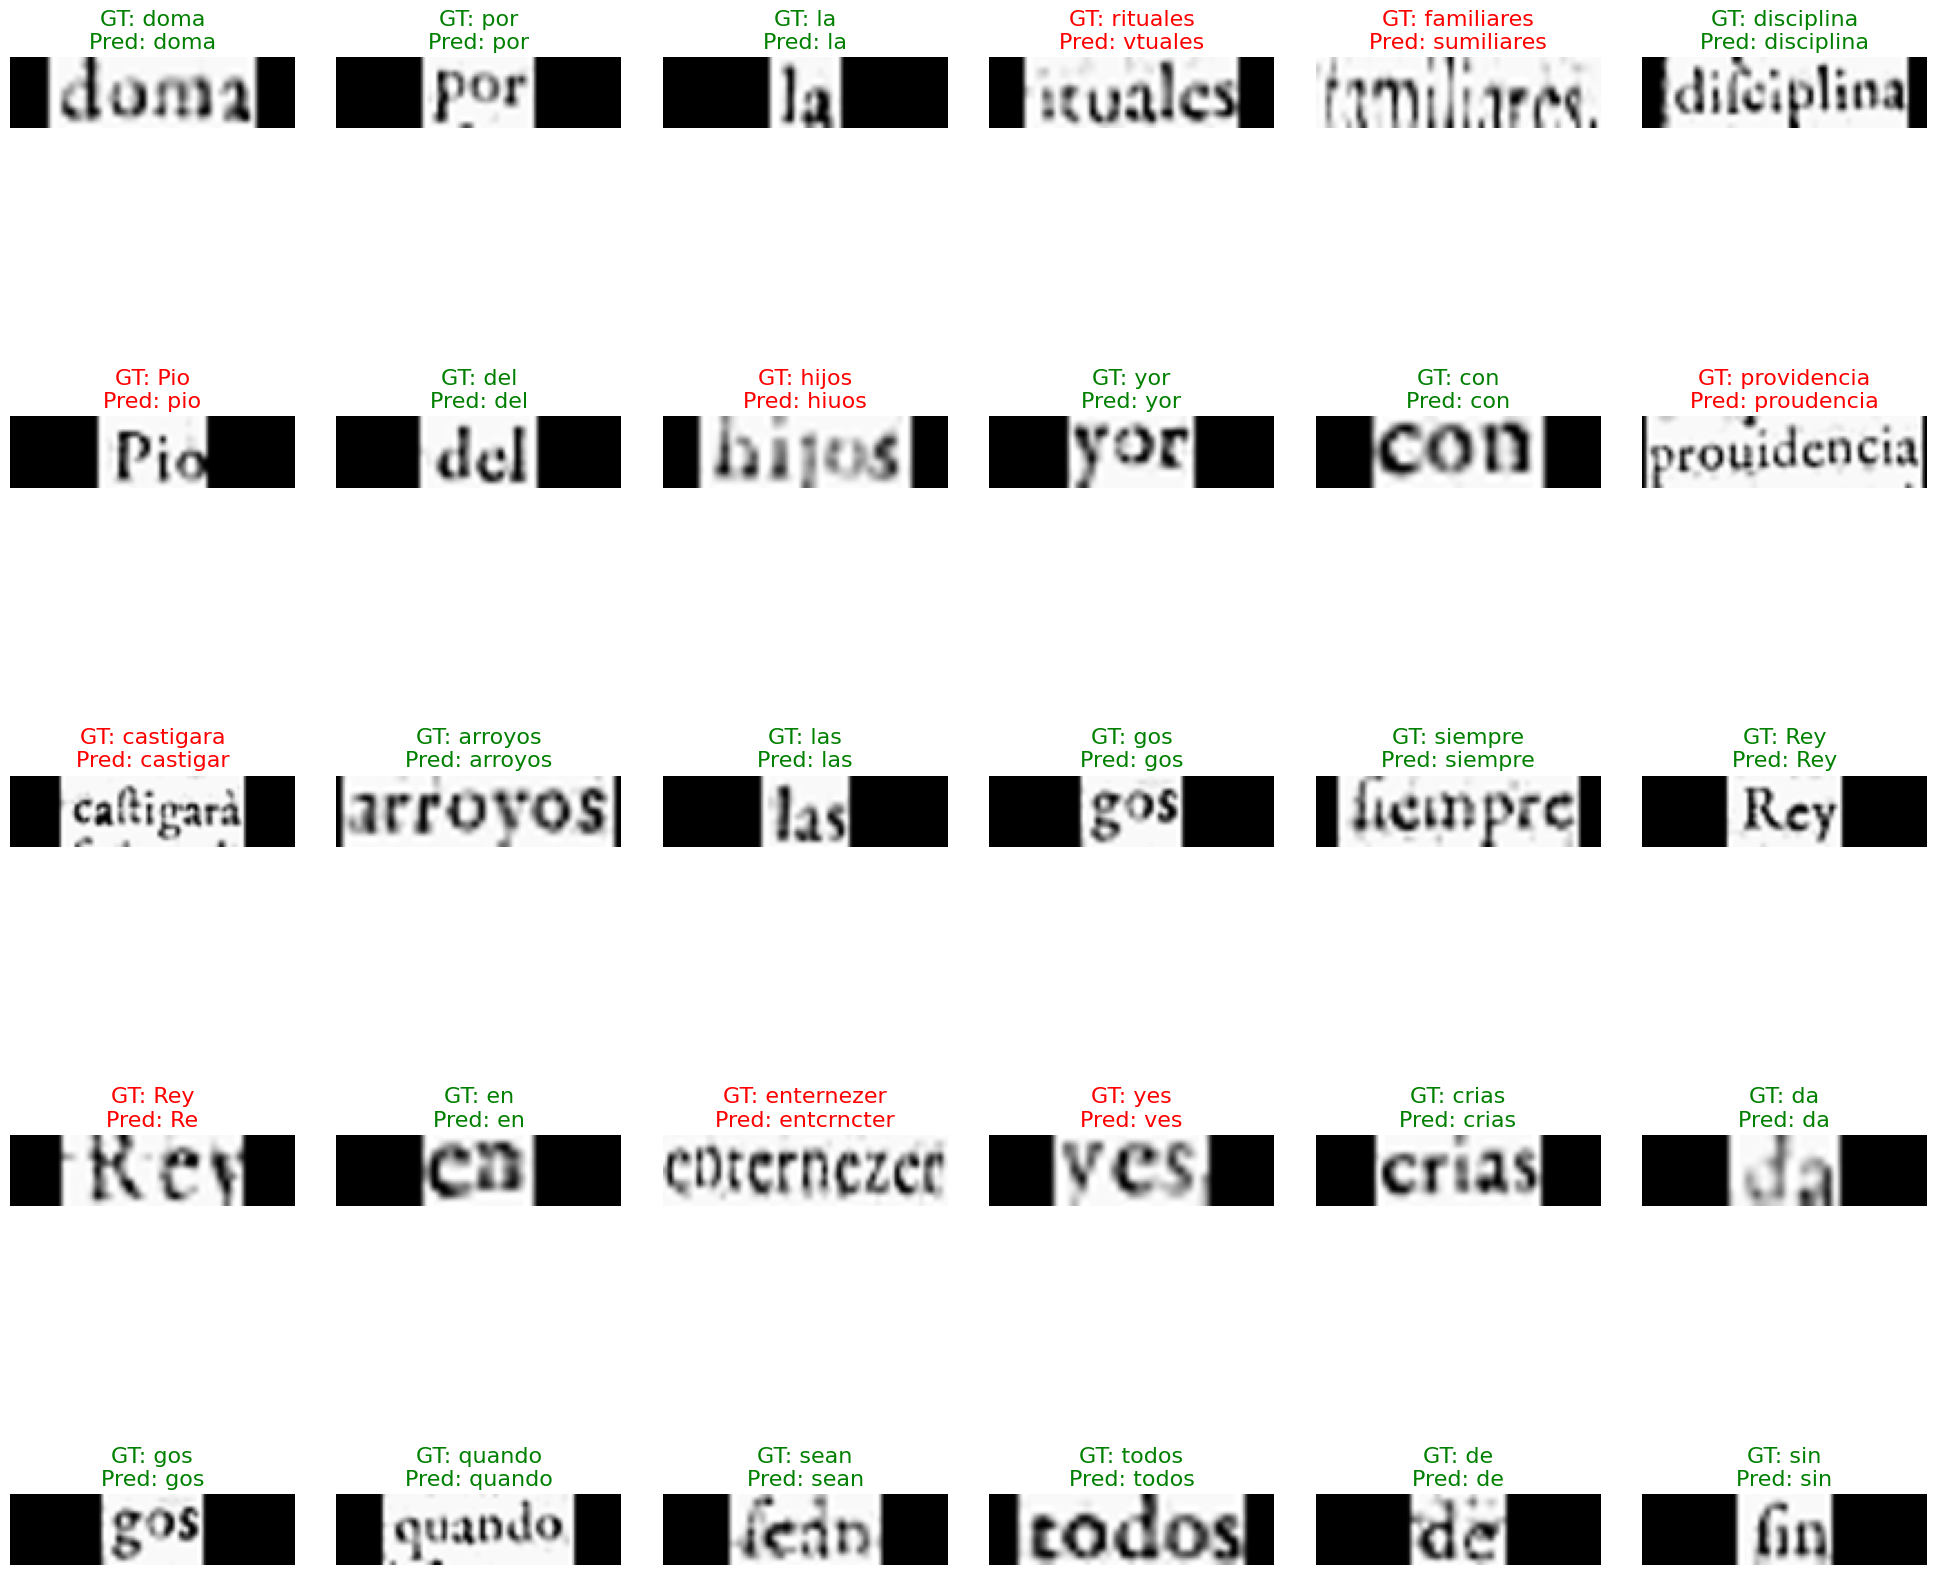

In [12]:
import torch
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


with torch.no_grad():
    images, _, _, label_strs = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)

    num_images = min(30, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        img_np = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        gt = label_strs[i]
        pred = preds[i]
        correct = (gt == pred)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np, cmap='gray')

        title_color = 'green' if correct else 'red'
        plt.title(f"GT: {gt}\nPred: {pred}", fontsize=16, color=title_color)
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


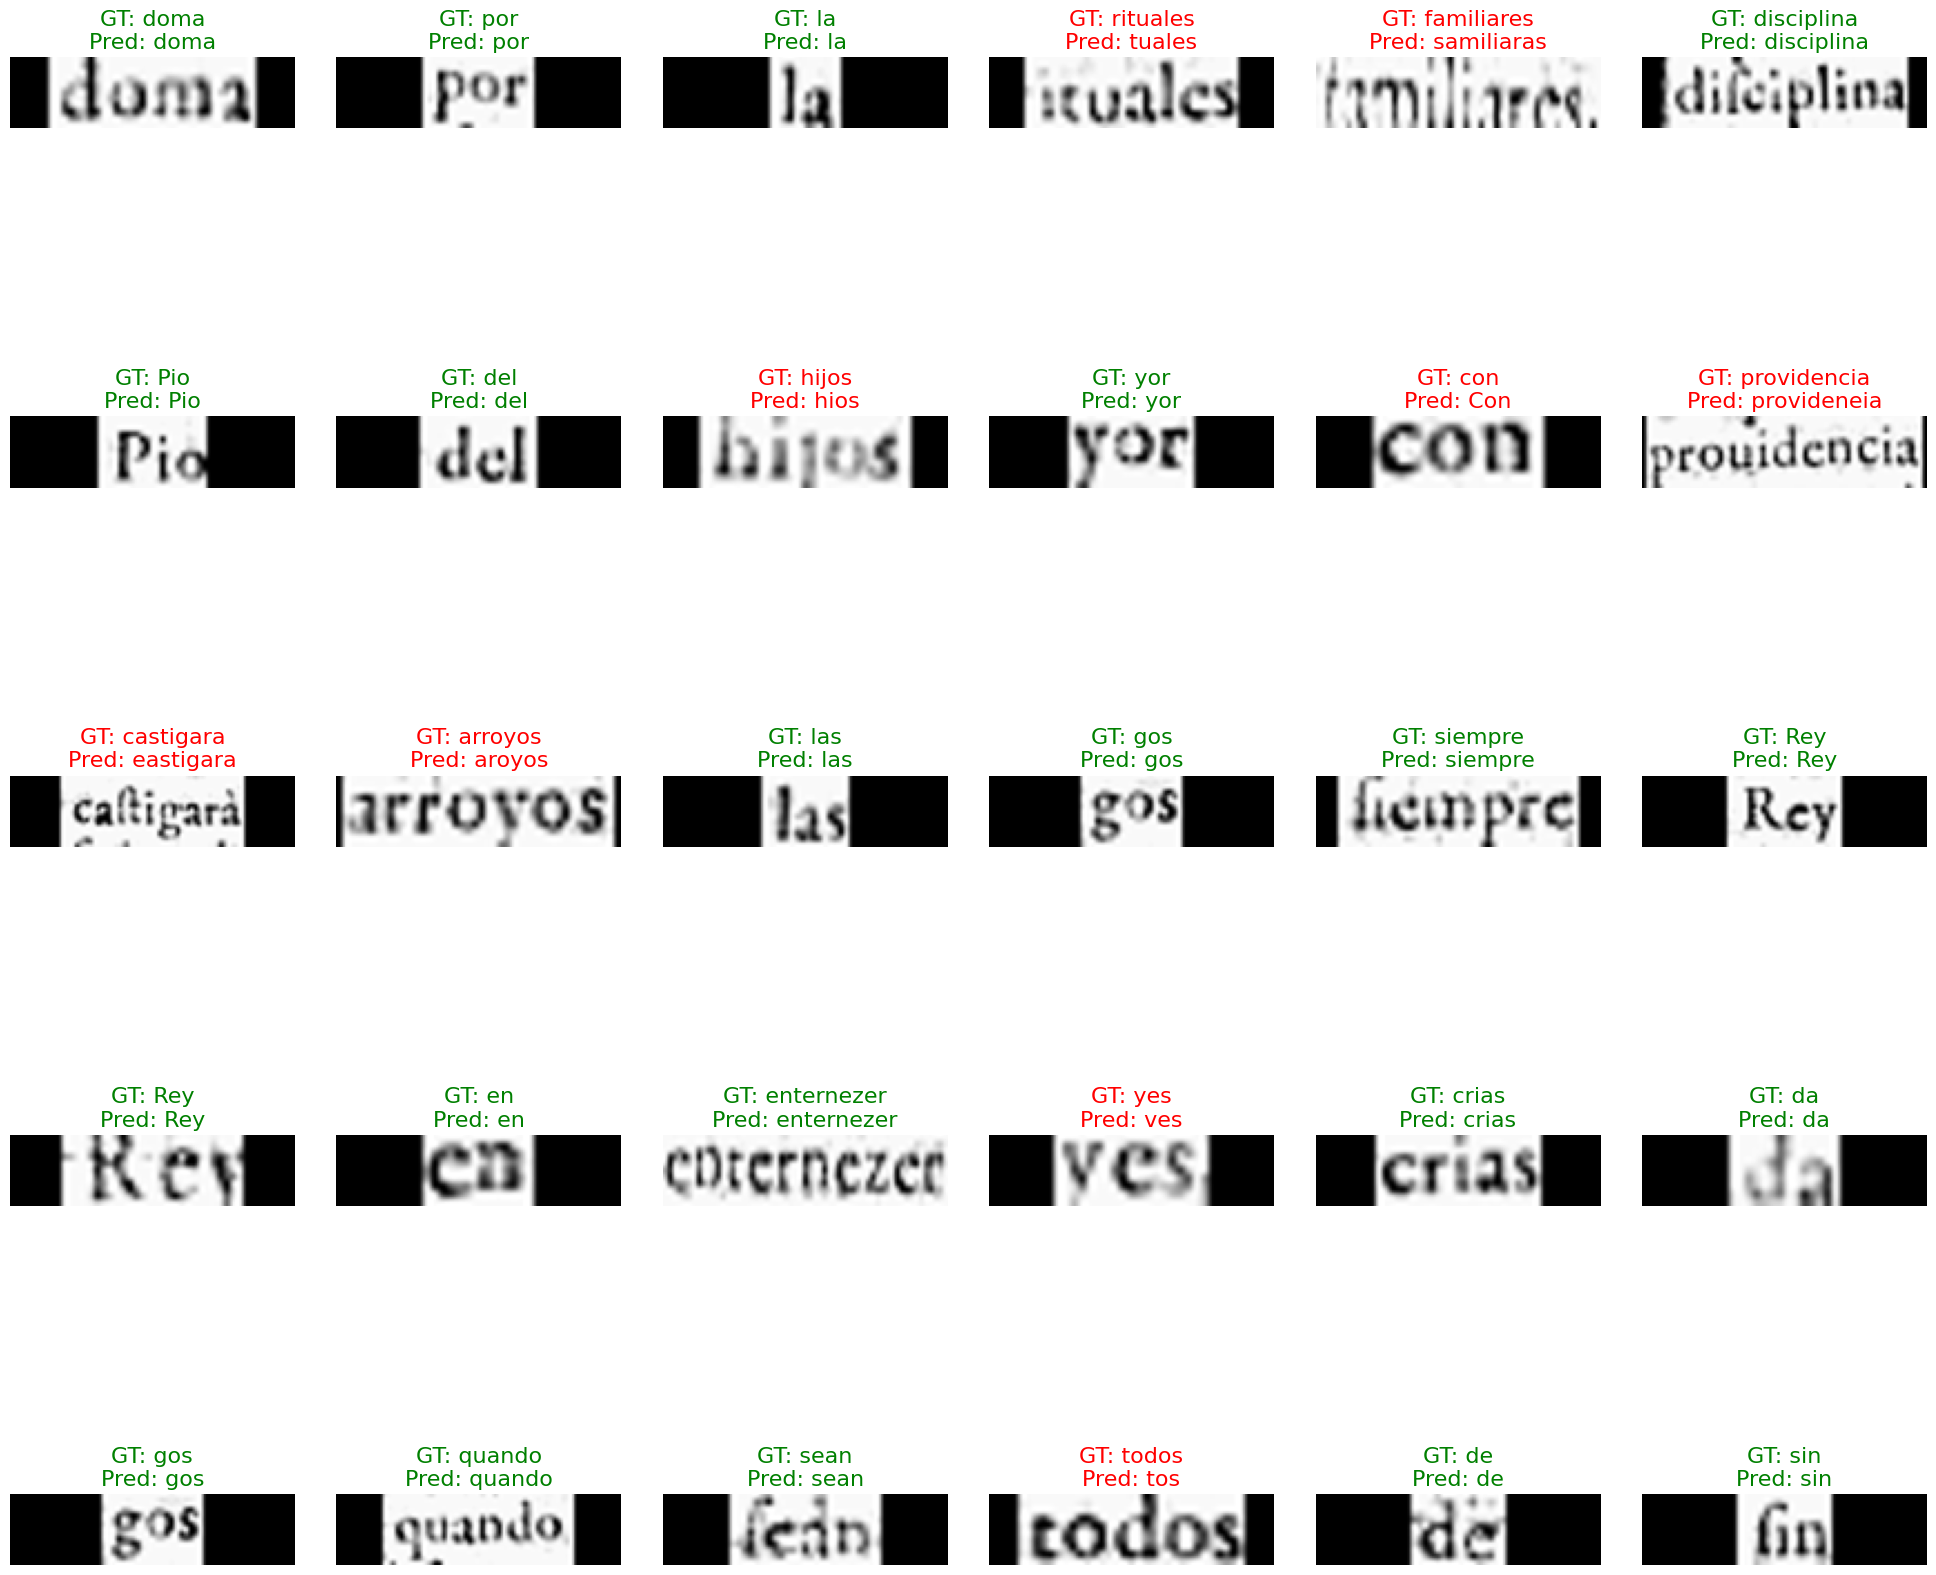

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Beam Search Decoder
def ctc_beam_search_decoder(probs, charset, beam_width=10, blank_index=0):
    T, C = probs.shape  # probs: [T, C]
    beams = [("", 1.0)]

    for t in range(T):
        new_beams = defaultdict(float)
        for prefix, score in beams:
            for c in range(C):
                p = probs[t, c]
                char = '' if c == blank_index else charset[c - 1]
                if char == '' or (len(prefix) > 0 and char == prefix[-1]):
                    new_seq = prefix
                else:
                    new_seq = prefix + char
                new_beams[new_seq] += score * p
        beams = sorted(new_beams.items(), key=lambda x: x[1], reverse=True)[:beam_width]
    return beams[0][0]  # best sequence

with torch.no_grad():
    images, _, _, label_strs = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)  # [T, B, C]
    log_probs = outputs.log_softmax(2).cpu()  # [T, B, C]
    T, B, C = log_probs.shape

    preds = []
    for b in range(B):
        probs_np = log_probs[:, b, :].exp().numpy()  # convert to prob
        pred = ctc_beam_search_decoder(probs_np, CHARSET, beam_width=5)
        preds.append(pred)

    # Visualization Grid
    num_images = min(30, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        img_np = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        gt = label_strs[i]
        pred = preds[i]
        correct = (gt == pred)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np, cmap='gray')

        title_color = 'green' if correct else 'red'
        plt.title(f"GT: {gt}\nPred: {pred}", fontsize=16, color=title_color)
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


In [22]:
import torch
import numpy as np
from collections import defaultdict
from jiwer import cer, wer

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild and load model
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Beam Search Decoder
def ctc_beam_search_decoder(probs, charset, beam_width=5, blank_index=0):
    T, C = probs.shape
    beams = [("", 1.0)]
    for t in range(T):
        new_beams = defaultdict(float)
        for prefix, score in beams:
            for c in range(C):
                p = probs[t, c]
                char = '' if c == blank_index else charset[c - 1]
                new_seq = prefix if char == '' or (len(prefix) > 0 and char == prefix[-1]) else prefix + char
                new_beams[new_seq] += score * p
        beams = sorted(new_beams.items(), key=lambda x: x[1], reverse=True)[:beam_width]
    return beams[0][0]

# Greedy Decoder
def greedy_decode(log_probs, charset):
    _, max_indices = log_probs.max(2)
    max_indices = max_indices.transpose(0, 1).cpu().numpy()
    results = []
    for indices in max_indices:
        pred = []
        prev = -1
        for i in indices:
            if i != prev and i != 0:
                pred.append(charset[i - 1])
            prev = i
        results.append(''.join(pred))
    return results

# Evaluation on full validation set
gt_texts = []
greedy_preds = []
beam_preds = []

with torch.no_grad():
    for images, _, _, label_strs in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        log_probs = outputs.log_softmax(2).cpu()

        T, B, C = log_probs.shape
        greedy_preds.extend(greedy_decode(log_probs, CHARSET))

        for b in range(B):
            probs_np = log_probs[:, b, :].exp().numpy()
            beam_pred = ctc_beam_search_decoder(probs_np, CHARSET, beam_width=5)
            beam_preds.append(beam_pred)

        gt_texts.extend(label_strs)

# Global CER/WER
print(f"\nEvaluation on {len(gt_texts)} samples")
print(f"Greedy   CER: {cer(' '.join(gt_texts), ' '.join(greedy_preds)):.4f} | WER: {wer(' '.join(gt_texts), ' '.join(greedy_preds)):.4f}")
print(f"Beam     CER: {cer(' '.join(gt_texts), ' '.join(beam_preds)):.4f} | WER: {wer(' '.join(gt_texts), ' '.join(beam_preds)):.4f}")

# Per-sample CERs
print("\nPer-sample CER (first 20 shown):")
for i, (gt, g_pred, b_pred) in enumerate(zip(gt_texts, greedy_preds, beam_preds)):
    print(f"\nSample {i+1}")
    print(f"GT:     {gt}")
    print(f"Greedy: {g_pred}")
    print(f"  CER: {cer(gt, g_pred):.2f}")
    print(f"Beam:   {b_pred}")
    print(f"  CER: {cer(gt, b_pred):.2f}")
    if i >= 19:
        break  # Show first 20 samples only



Evaluation on 412 samples
Greedy   CER: 0.0873 | WER: 0.3285
Beam     CER: 0.0922 | WER: 0.3454

Per-sample CER (first 20 shown):

Sample 1
GT:     doma
Greedy: doma
  CER: 0.00
Beam:   doma
  CER: 0.00

Sample 2
GT:     por
Greedy: por
  CER: 0.00
Beam:   por
  CER: 0.00

Sample 3
GT:     la
Greedy: la
  CER: 0.00
Beam:   la
  CER: 0.00

Sample 4
GT:     rituales
Greedy: ttuales
  CER: 0.25
Beam:   tuales
  CER: 0.25

Sample 5
GT:     familiares
Greedy: samiliaras
  CER: 0.20
Beam:   samiliaras
  CER: 0.20

Sample 6
GT:     disciplina
Greedy: disciplina
  CER: 0.00
Beam:   disciplina
  CER: 0.00

Sample 7
GT:     Pio
Greedy: Pio
  CER: 0.00
Beam:   Pio
  CER: 0.00

Sample 8
GT:     del
Greedy: del
  CER: 0.00
Beam:   del
  CER: 0.00

Sample 9
GT:     hijos
Greedy: hios
  CER: 0.20
Beam:   hios
  CER: 0.20

Sample 10
GT:     yor
Greedy: yor
  CER: 0.00
Beam:   yor
  CER: 0.00

Sample 11
GT:     con
Greedy: Con
  CER: 0.33
Beam:   Con
  CER: 0.33

Sample 12
GT:     providencia
Greedy: 

In [24]:
import os
from torchvision.utils import save_image

# Create folder to store bad samples
os.makedirs("bad_preds", exist_ok=True)

model.eval()
failed_samples = []

with torch.no_grad():
    images, _, _, label_strs = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)

    for i in range(len(images)):
        gt = label_strs[i]
        pred = preds[i]
        correct = (gt == pred)

        # Save and log only incorrect predictions
        if not correct:
            img_tensor = images[i].cpu()
            filename = f"bad_preds/img_{i:03d}_GT_{gt}_PRED_{pred}.png"

            # Log in memory
            failed_samples.append({
                "index": i,
                "ground_truth": gt,
                "prediction": pred,
                "image_path": filename
            })

            # Save image to disk
            save_image(img_tensor, filename)

# Optional: view list of failed samples
for sample in failed_samples:
    print(f"[FAIL] GT: {sample['ground_truth']} | PRED: {sample['prediction']} → {sample['image_path']}")


[FAIL] GT: rituales | PRED: ttuales → bad_preds/img_003_GT_rituales_PRED_ttuales.png
[FAIL] GT: familiares | PRED: samiliaras → bad_preds/img_004_GT_familiares_PRED_samiliaras.png
[FAIL] GT: hijos | PRED: hios → bad_preds/img_008_GT_hijos_PRED_hios.png
[FAIL] GT: con | PRED: Con → bad_preds/img_010_GT_con_PRED_Con.png
[FAIL] GT: providencia | PRED: provideneia → bad_preds/img_011_GT_providencia_PRED_provideneia.png
[FAIL] GT: castigara | PRED: eastigara → bad_preds/img_012_GT_castigara_PRED_eastigara.png
[FAIL] GT: yes | PRED: ves → bad_preds/img_021_GT_yes_PRED_ves.png
[FAIL] GT: todos | PRED: toos → bad_preds/img_027_GT_todos_PRED_toos.png
[FAIL] GT: Socrates | PRED: Mociates → bad_preds/img_030_GT_Socrates_PRED_Mociates.png


In [25]:
from jiwer import wer, cer

# After decoding
pred_texts = preds
gt_texts = list(label_strs)  # Convert tuple to list

# Compute average metrics
avg_cer = cer(gt_texts, pred_texts)
avg_wer = wer(gt_texts, pred_texts)

print(f"CER: {avg_cer:.4f} | WER: {avg_wer:.4f}")


CER: 0.0745 | WER: 0.2812


Bad Predictions CSV

In [26]:
import pandas as pd

df_bad = pd.DataFrame(failed_samples)  # from your earlier list
df_bad.to_csv("data/bad_preds.csv", index=False)


In [27]:
class BadPredictionDataset(Dataset):
    def __init__(self, csv_path, transform, charset):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.charset = charset
        self.char_to_idx = {c: i + 1 for i, c in enumerate(charset)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('L')
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img = self.transform(img)
        label_str = row['ground_truth']
        label = [self.char_to_idx[c] for c in label_str if c in self.char_to_idx]
        return img, torch.tensor(label, dtype=torch.long), len(label), label_str


In [45]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

bad_dataset = BadPredictionDataset('data/bad_preds.csv', transform=transform, charset=CHARSET)
bad_loader = DataLoader(bad_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)



Add Spanish Dictionary to Beam Search

In [38]:
from pathlib import Path

# List of your dictionary files
dict_files = [
    "dictionaries/Diccionario.Espanol.136k.palabras.txt",
    "dictionaries/Diccionario.Espanol.no.special.characters.no.tilde.no.n.txt",
    "dictionaries/Diccionario.Espanol.no.special.characters.no.tilde.txt",
    "dictionaries/spanish_words.txt"
]

# Combine and clean
combined_words = set()
for file in dict_files:
    with open(file, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            word = line.strip().lower()
            if word:
                combined_words.add(word)

print(f"Combined dictionary size: {len(combined_words)}")

# Optionally save to a file
with open("combined_spanish_lexicon.txt", "w", encoding="utf-8") as f:
    for word in sorted(combined_words):
        f.write(f"{word}\n")


Combined dictionary size: 230192


In [39]:
import numpy as np
from difflib import SequenceMatcher
from unidecode import unidecode
from rapidfuzz import process, fuzz
from collections import defaultdict

def normalized_edit_distance(a, b):
    """Compute normalized edit distance (0.0 = perfect match, 1.0 = completely different)."""
    return 1 - SequenceMatcher(None, a, b).ratio()

# Precompute: bucket normalized lexicon by word length
def build_length_buckets(lexicon):
    buckets = defaultdict(list)
    for word in lexicon:
        norm = unidecode(word.lower())
        buckets[len(norm)].append((norm, word))
    return buckets

# --- Load Lexicon ---
try:
    with open("combined_spanish_lexicon.txt", "r", encoding="latin1") as f:
        SPANISH_WORDS = set(w.strip() for w in f if w.strip())
except Exception as e:
    print("Failed to load lexicon:", e)
    SPANISH_WORDS = set()

LEXICON_BUCKETS = build_length_buckets(SPANISH_WORDS)

def correct_with_lexicon(
    seq,
    lexicon_buckets,
    length_tolerance=0,
    min_similarity=87,
    min_word_len=0,
    prefix_agreement=0,  # new: how much of the prefix must agree
    verbose=False
):
    original_seq = seq  # preserve original casing
    seq = seq.strip()
    norm_seq = unidecode(seq.lower())
    seq_len = len(norm_seq)

    if seq_len < min_word_len:
        return seq

    candidates = []
    for l in range(seq_len - length_tolerance, seq_len + length_tolerance + 1):
        candidates.extend(lexicon_buckets.get(l, []))  # (normalized, original)

    if not candidates:
        return seq

    # Prefer exact normalized match
    for norm_word, orig_word in candidates:
        if norm_word == norm_seq:
            if orig_word.lower() == seq.lower():
                return original_seq
            return orig_word

    # Fuzzy match with filtering
    best = process.extractOne(
        norm_seq,
        [w[0] for w in candidates],
        scorer=fuzz.ratio,
        score_cutoff=min_similarity
    )

    if best:
        matched_norm, score, _ = best
        for norm_word, orig_word in candidates:
            if norm_word == matched_norm:
                # Reject if not enough prefix match
                prefix_len = int(seq_len * prefix_agreement)
                if not norm_seq.startswith(norm_word[:prefix_len]):
                    if verbose:
                        print(f"[SKIP] Prefix mismatch: '{seq}' vs '{orig_word}'")
                    continue

                if orig_word.lower() == seq.lower():
                    return original_seq
                if verbose:
                    print(f"[MATCH] '{seq}' → '{orig_word}' (score: {score})")
                return orig_word

    return seq



In [40]:
import torch
import numpy as np
from collections import defaultdict
from jiwer import cer, wer
from unidecode import unidecode
from difflib import SequenceMatcher
from pathlib import Path


# --- Beam Decoder ---
def ctc_beam_search_decoder(probs, charset, beam_width=5, blank_index=0):
    T, C = probs.shape
    beams = [("", 1.0)]
    for t in range(T):
        new_beams = defaultdict(float)
        for prefix, score in beams:
            for c in range(C):
                p = probs[t, c]
                char = '' if c == blank_index else charset[c - 1]
                new_seq = prefix if char == '' or (len(prefix) > 0 and char == prefix[-1]) else prefix + char
                new_beams[new_seq] += score * p
        beams = sorted(new_beams.items(), key=lambda x: x[1], reverse=True)[:beam_width]
    return beams[0][0]

# --- Load Model ---
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model_finetuned.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# --- Load Lexicon ---
try:
    with open("combined_spanish_lexicon.txt", "r", encoding="latin1") as f:
        SPANISH_WORDS = set(w.strip().lower() for w in f if w.strip())
except Exception as e:
    print("Failed to load lexicon:", e)
    SPANISH_WORDS = set()

# --- Run Evaluation ---
gt_texts = []
beam_preds_no_lex = []
beam_preds_with_lex = []

with torch.no_grad():
    for images, _, _, label_strs in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        log_probs = outputs.log_softmax(2).cpu()
        T, B, C = log_probs.shape
        for b in range(B):
            probs_np = log_probs[:, b, :].exp().numpy()
            pred_no_lex = ctc_beam_search_decoder(probs_np, CHARSET, beam_width=5)
            pred_with_lex = correct_with_lexicon(pred_no_lex, LEXICON_BUCKETS)
            beam_preds_no_lex.append(pred_no_lex)
            beam_preds_with_lex.append(pred_with_lex)
        gt_texts.extend(label_strs)

# --- Report Results ---
print(f"\nEvaluation on {len(gt_texts)} samples")
print(f"Beam (no lexicon) CER: {cer(gt_texts, beam_preds_no_lex):.4f} | WER: {wer(gt_texts, beam_preds_no_lex):.4f}")
print(f"Beam (with lexicon)  CER: {cer(gt_texts, beam_preds_with_lex):.4f} | WER: {wer(gt_texts, beam_preds_with_lex):.4f}")



Evaluation on 538 samples
Beam (no lexicon) CER: 0.1312 | WER: 0.3370
Beam (with lexicon)  CER: 0.1392 | WER: 0.3552


In [41]:
from termcolor import colored
from jiwer import wer, cer

lexicon_helped = 0
lexicon_hurt = 0

print("\nLexicon Impact on Predictions:\n")
for gt, no_lex, with_lex in zip(gt_texts, beam_preds_no_lex, beam_preds_with_lex):
    if no_lex != with_lex:
        # Compute per-sample WER
        wer_no_lex = wer(gt, no_lex)
        wer_with_lex = wer(gt, with_lex)

        if wer_with_lex < wer_no_lex:
            color = "green"
            lexicon_helped += 1
        elif wer_with_lex > wer_no_lex:
            color = "red"
            lexicon_hurt += 1
        else:
            color = "yellow"

        print(colored(f"[GT]        {gt}", "cyan"))
        print(colored(f"[Beam]      {no_lex}", "magenta"))
        print(colored(f"[Lexicon]   {with_lex} (WER: {wer_with_lex:.2f})", color))
        print()

print(f"Lexicon improved {lexicon_helped} predictions.")
print(f"Lexicon worsened {lexicon_hurt} predictions.")
print(f"Unchanged or equal: {len(gt_texts) - lexicon_helped - lexicon_hurt}")



Lexicon Impact on Predictions:

[GT]        adulterio
[Beam]      aulterio
[Lexicon]   cauterio (WER: 1.00)

[GT]        prudencias
[Beam]      prudencias
[Lexicon]   prudencial (WER: 1.00)

[GT]        sentimiento
[Beam]      sentimiento
[Lexicon]   sentamiento (WER: 1.00)

[GT]        personas
[Beam]      personas
[Lexicon]   personad (WER: 1.00)

[GT]        entienden
[Beam]      entienden
[Lexicon]   extienden (WER: 1.00)

[GT]        estiman v
[Beam]      estimany
[Lexicon]   estimarn (WER: 1.00)

[GT]        soberania
[Beam]      tiranica
[Lexicon]   tiranice (WER: 1.00)

[GT]        perfeccion
[Beam]      perfecion
[Lexicon]   perfeccin (WER: 1.00)

[GT]        Emperador
[Beam]      Empgrador
[Lexicon]   emperador (WER: 1.00)

[GT]        licencio
[Beam]      sicencio
[Lexicon]   silencio (WER: 1.00)

[GT]        agradecidos
[Beam]      agradecidos
[Lexicon]   agradecimos (WER: 1.00)

[GT]        Escritura
[Beam]      Escritura
[Lexicon]   escriture (WER: 1.00)

[GT]        Pre

Create New Dataset using New Data

In [109]:
from utils import pad_and_resize_images, create_csv_from_folder

pad_and_resize_images("cropped")
create_csv_from_folder("cropped", "train_new_data.csv")

Processed: cropped\&.jpg
Processed: cropped\(47).jpg
Processed: cropped\(49).jpg
Processed: cropped\(51).jpg
Processed: cropped\(53).jpg
Processed: cropped\(55).jpg
Processed: cropped\(58).jpg
Processed: cropped\(6.jpg
Processed: cropped\(61.jpg
Processed: cropped\(aun.jpg
Processed: cropped\(Christianamen.jpg
Processed: cropped\(pero.jpg
Processed: cropped\, como.jpg
Processed: cropped\,acusado.jpg
Processed: cropped\,como_1.jpg
Processed: cropped\,como_2.jpg
Processed: cropped\,con.jpg
Processed: cropped\,de.jpg
Processed: cropped\,ne.jpg
Processed: cropped\,qui.jpg
Processed: cropped\,vel.jpg
Processed: cropped\1.per.jpg
Processed: cropped\109.jpg
Processed: cropped\10_1.jpg
Processed: cropped\12.q.jpg
Processed: cropped\2)pero.jpg
Processed: cropped\20.jpg
Processed: cropped\20_1.jpg
Processed: cropped\3..jpg
Processed: cropped\3.cap.jpg
Processed: cropped\3.tom.jpg
Processed: cropped\30.jpg
Processed: cropped\50).jpg
Processed: cropped\50.jpg
Processed: cropped\54).jpg
Processed: 

Combine with Previous CSV

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Load all three sources ---
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("train_new_data.csv")
df_val = pd.read_csv("val.csv")

# --- Combine all ---
combined_df = pd.concat([df1, df2, df_val], ignore_index=True)

# --- Clean up: remove missing or empty IDENTITYs ---
combined_df["IDENTITY"] = combined_df["IDENTITY"].astype(str).str.strip()
combined_df = combined_df[combined_df["IDENTITY"].astype(bool)]  # remove empty strings / NaN

# --- Optional: shuffle entire set ---
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
combined_df["FILENAME"] = combined_df["FILENAME"].apply(lambda x: str(Path(x).as_posix()))


# --- Split into 90% train, 10% val ---
train_df, val_df = train_test_split(combined_df, test_size=0.1, random_state=42)

# --- Save to disk ---
train_df.to_csv("train_new.csv", index=False)
val_df.to_csv("val_new.csv", index=False)

print(f"Final datasets:")
print(f" - train.csv: {len(train_df)} samples")
print(f" - val.csv:   {len(val_df)} samples")


Final datasets:
 - train.csv: 4852 samples
 - val.csv:   540 samples


New DataLoader

In [18]:
train_dataset = OCRDataset('csv/train_new.csv', transform=transform, char_to_idx=char_to_idx)
val_dataset = OCRDataset('csv/val_new.csv', transform=transform, char_to_idx=char_to_idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Train on New Data

In [20]:
# Ensure DEVICE is defined
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)

# Load previous checkpoint
checkpoint = torch.load("best_model_finetuned.pth", map_location=DEVICE)
# Load all layers except the embedding layer (output layer)
state_dict = checkpoint["model_state_dict"]
model_state = model.state_dict()
# Remove embedding weights/bias if shape mismatch
for key in ["embedding.weight", "embedding.bias"]:
	if key in state_dict and model_state[key].shape != state_dict[key].shape:
		print(f"Skipping {key} due to shape mismatch: {model_state[key].shape} vs {state_dict[key].shape}")
		del state_dict[key]
model.load_state_dict(state_dict, strict=False)

# Optionally resume optimizer state (recommended for consistent learning rate behavior)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Restore epoch number if needed:
start_epoch = checkpoint.get("epoch", 0) + 1


In [46]:

if model is None:
    raise ValueError("Model is not initialized. Please run the cell that initializes and loads the model before running this training loop.")

early_stopper = EarlyStopping(patience=5)
best_val_loss = float('inf')

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels_concat, label_lengths, _ in train_loader:
        images = images.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)

        outputs = model(images)
        if outputs is None:
            raise ValueError("Model forward() returned None. Check your CRNN forward method.")
        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)
        loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels_concat, label_lengths, _ in val_loader:
            images = images.to(DEVICE)
            labels_concat = labels_concat.to(DEVICE)
            outputs = model(images)
            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)
            loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_checkpoint(model, optimizer, epoch, path='best_model.pth')
        print("Saved best model.")

    if early_stopper.step(avg_val_loss):
        print("Early stopping triggered.")
        break

Epoch 1, Train Loss: 0.4653, Val Loss: 0.4074
Saved best model.
Epoch 2, Train Loss: 0.3675, Val Loss: 0.3911
Saved best model.
Epoch 3, Train Loss: 0.3204, Val Loss: 0.3552
Saved best model.
Epoch 4, Train Loss: 0.2869, Val Loss: 0.4178
Epoch 5, Train Loss: 0.2620, Val Loss: 0.3267
Saved best model.
Epoch 6, Train Loss: 0.2287, Val Loss: 0.3327
Epoch 7, Train Loss: 0.2172, Val Loss: 0.3993
Epoch 8, Train Loss: 0.2031, Val Loss: 0.3328
Epoch 9, Train Loss: 0.1860, Val Loss: 0.3684
Epoch 10, Train Loss: 0.1765, Val Loss: 0.3489
Early stopping triggered.


In [36]:
import torch
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Bat

In [37]:
print(model)

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Bat

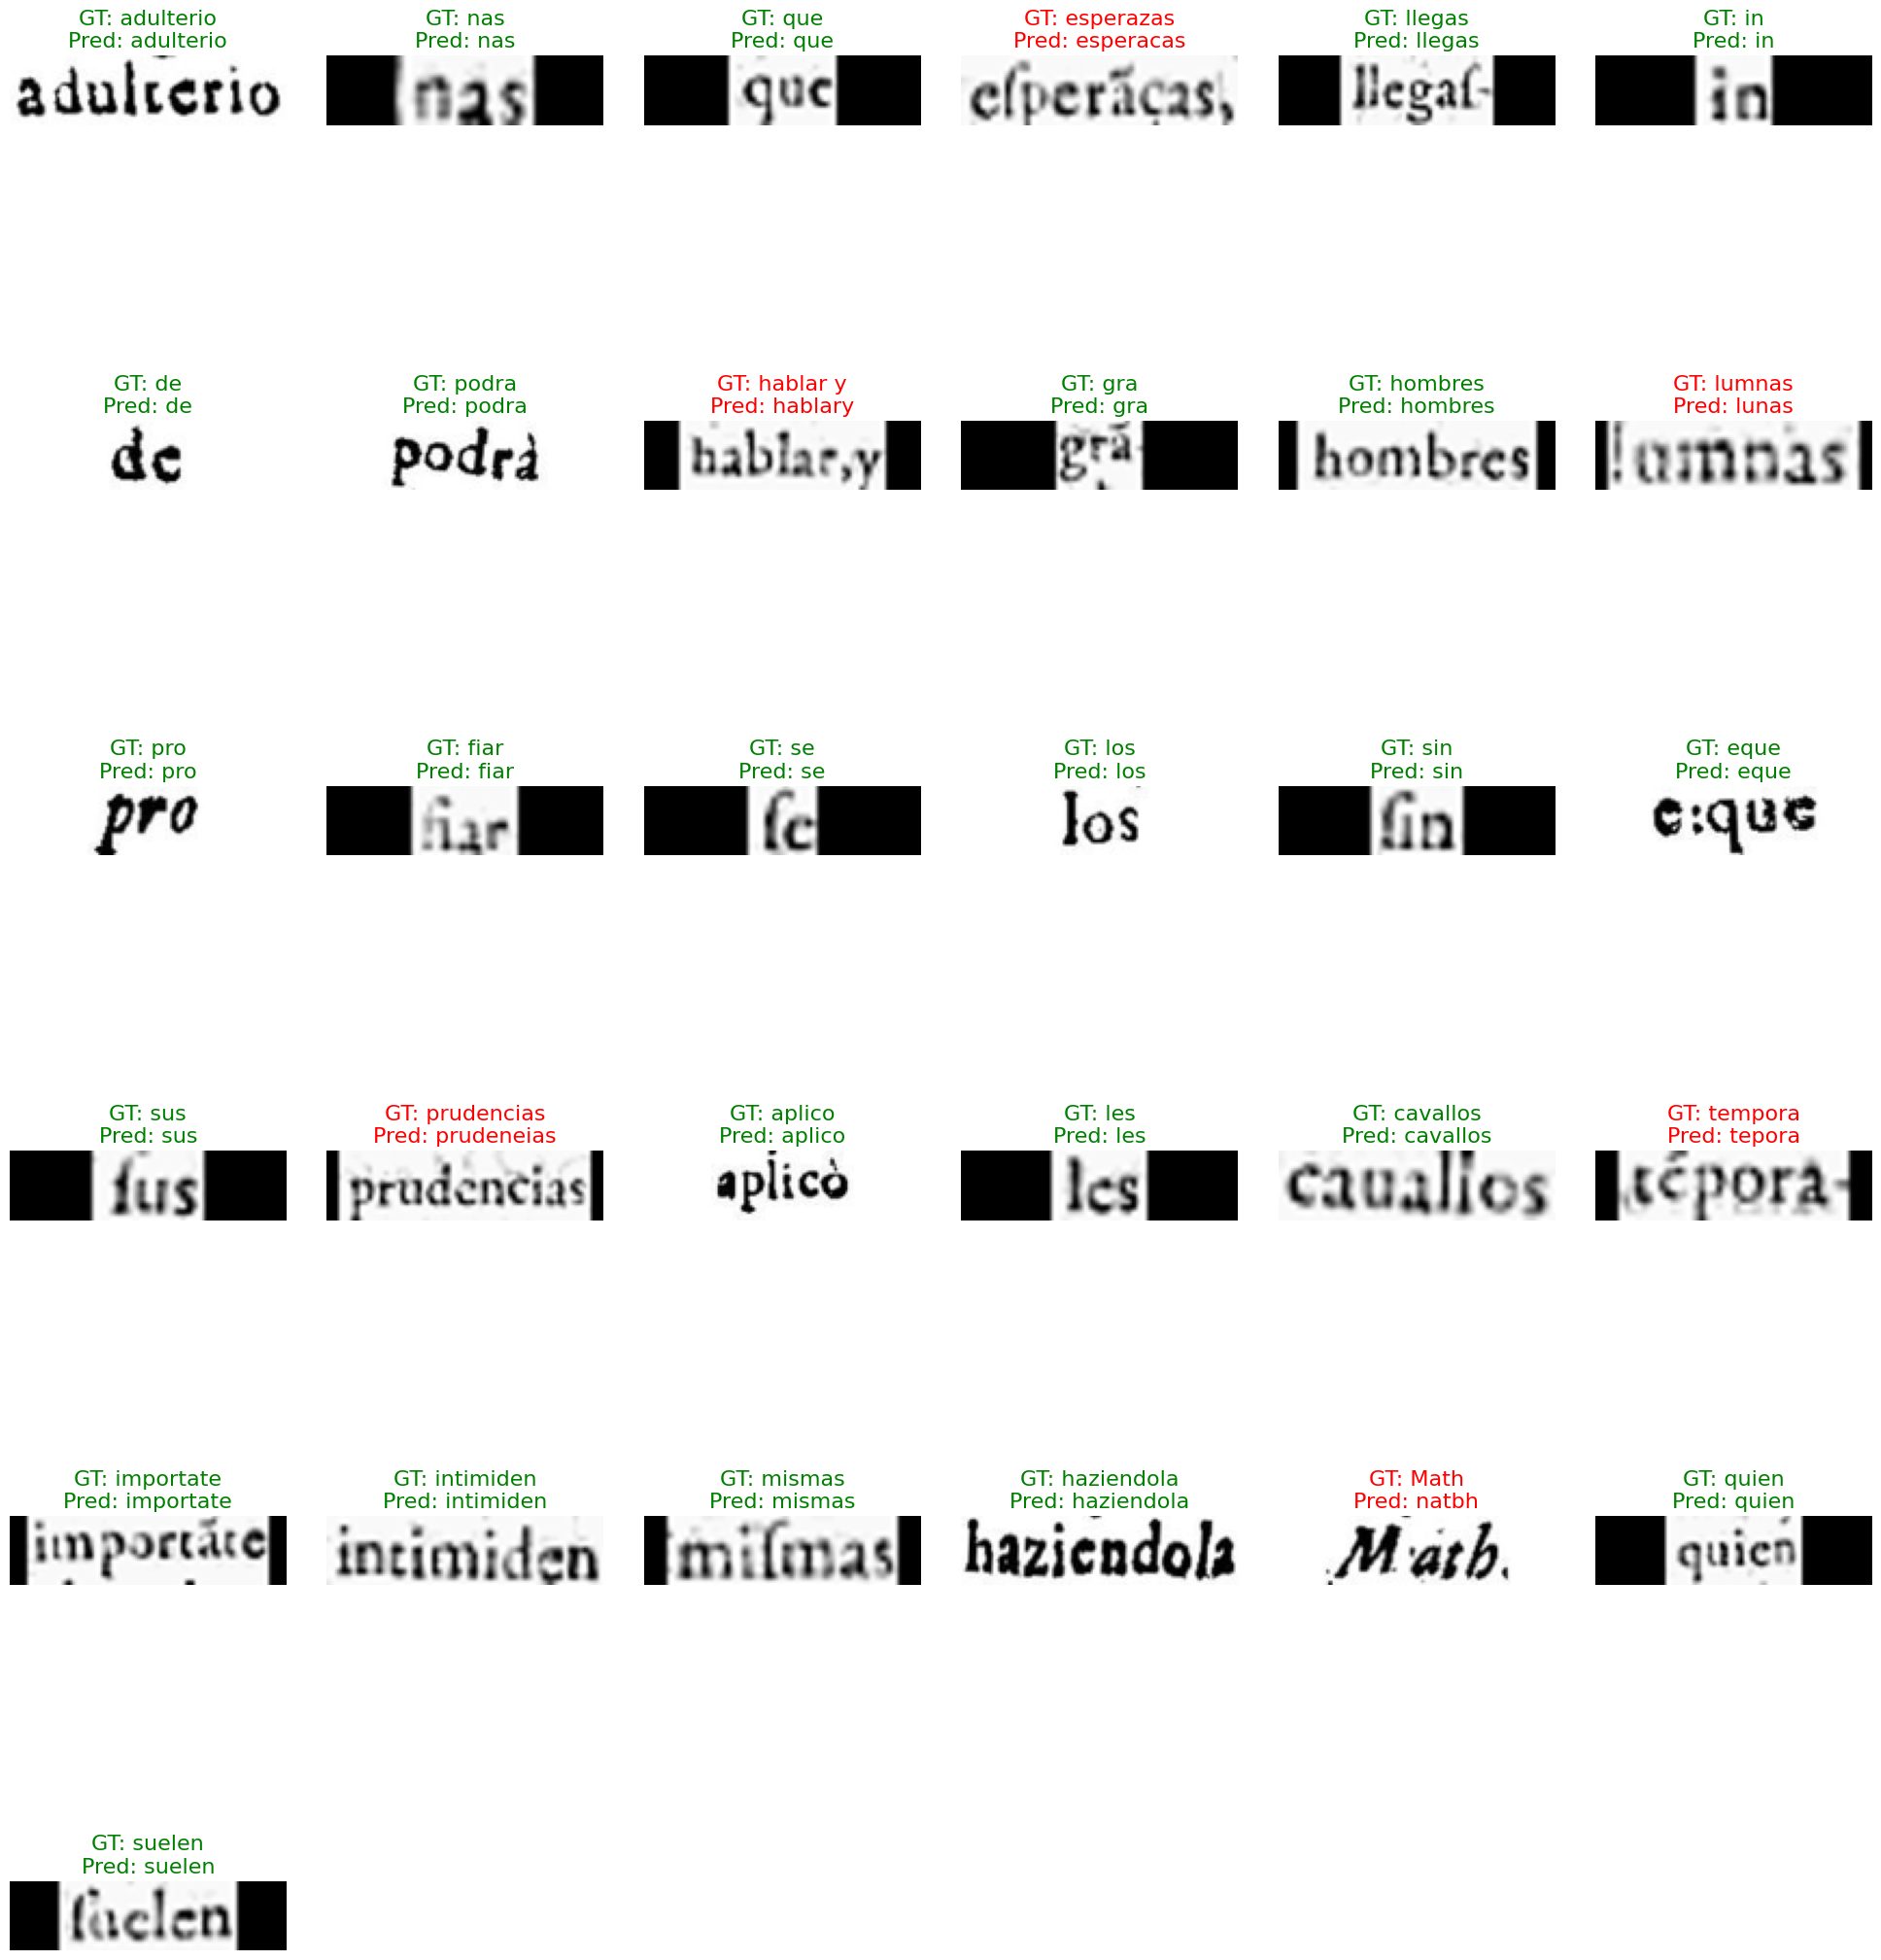

In [ ]:
import torch
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


with torch.no_grad():
    images, _, _, label_strs = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)

    num_images = min(32, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        img_np = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        gt = label_strs[i]
        pred = preds[i]
        correct = (gt == pred)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np, cmap='gray')

        title_color = 'green' if correct else 'red'
        plt.title(f"GT: {gt}\nPred: {pred}", fontsize=16, color=title_color)
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


In [63]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class OCRTestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, img_path  # return path to identify output


In [78]:
import pandas as pd
from pathlib import Path

# Load validation CSV
val_df = pd.read_csv("csv/val.csv")

# Only keep rows where the image file still exists
val_df = val_df[val_df["FILENAME"].apply(lambda x: Path(x).is_file())]

# Sample N examples
n = 100
sampled = val_df.sample(n=min(n, len(val_df)), random_state=42).reset_index(drop=True)

# Remove the FILENAME column to create a test CSV
test_df = sampled[['FILENAME']]
test_df.to_csv("csv/test.csv", index=False)

print(f"✅ Created test.csv with {len(test_df)} entries from valid files.")


✅ Created test.csv with 100 entries from valid files.


In [79]:
test_dataset = OCRTestDataset('csv/test.csv', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

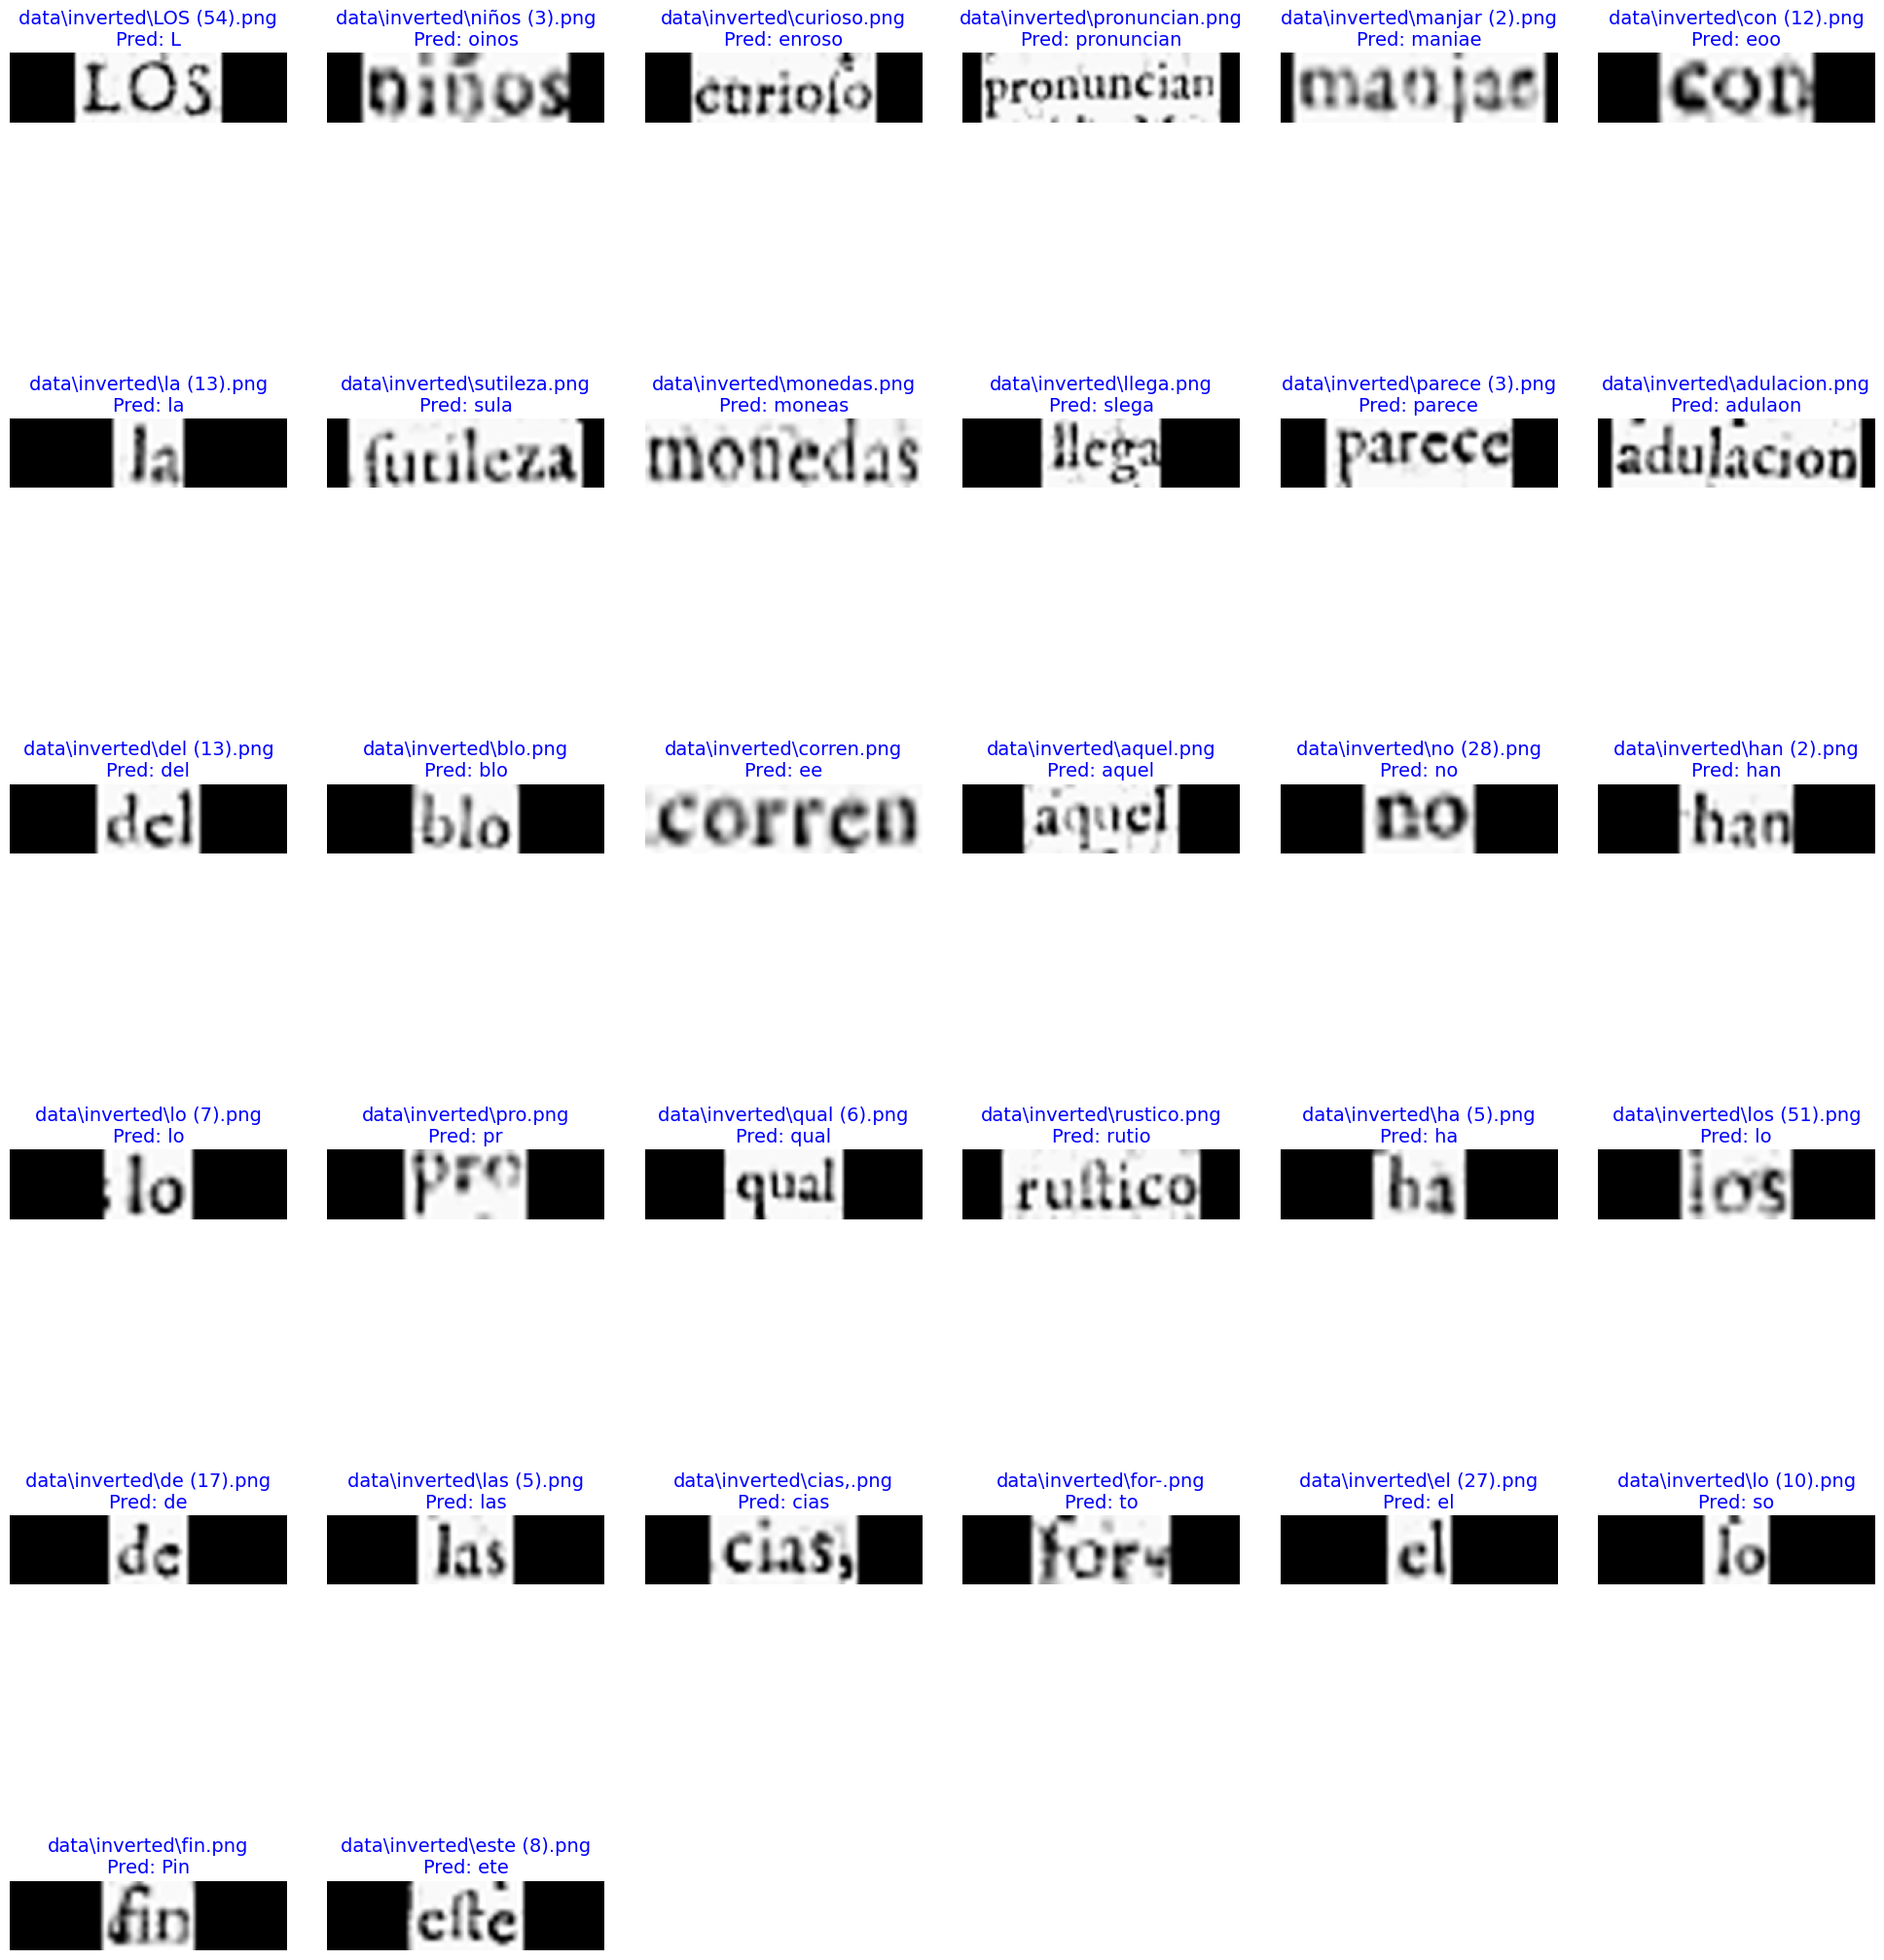

In [80]:
import torch
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

with torch.no_grad():
    images, paths = next(iter(test_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)  # Greedy decoder

    num_images = min(32, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        img_np = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        pred = preds[i]
        img_name = paths[i].split('/')[-1]  # filename only

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"{img_name}\nPred: {pred}", fontsize=14, color='blue')
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


In [34]:
import torch
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Accumulate misclassified samples
misclassified = []

with torch.no_grad():
    for images, _, _, label_strs in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = decode(outputs)  # Your greedy decoder

        for i in range(len(images)):
            gt = label_strs[i]
            pred = preds[i]
            if gt != pred:
                misclassified.append((images[i].cpu(), gt, pred))

# Display misclassified images
num_images = len(misclassified)
if num_images == 0:
    print("✅ All predictions are correct!")
else:
    cols = 6
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(20, rows * 4))

    for idx, (img, gt, pred) in enumerate(misclassified):
        img_np = img.squeeze().numpy() * 0.5 + 0.5  # unnormalize
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"GT: {gt}\nPred: {pred}", color='red', fontsize=14)
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


c:\Users\katej\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:70: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


FileNotFoundError: Could not open image: data\inverted\mucha (3).png
[Errno 2] No such file or directory: 'data\\inverted\\mucha (3).png'

In [43]:
from jiwer import wer, cer

# After decoding
pred_texts = preds
gt_texts = list(label_strs)  # Convert tuple to list

# Ensure both lists are the same length
min_len = min(len(gt_texts), len(pred_texts))
gt_texts = gt_texts[:min_len]
pred_texts = pred_texts[:min_len]

# Compute average metrics
avg_cer = cer(gt_texts, pred_texts)
avg_wer = wer(gt_texts, pred_texts)

print(f"CER: {avg_cer:.4f} | WER: {avg_wer:.4f}")


CER: 0.0395 | WER: 0.2121


In [39]:

import torch
from fast_ctc_decode import beam_search
from jiwer import cer, wer

# --- Load model ---
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# --- Evaluation ---
greedy_preds = []
beam_preds = []
gt_texts = []

with torch.no_grad():
    for images, _, _, label_strs in val_loader:
        images = images.to(DEVICE)
        output = model(images)  # [T, B, C]
        log_probs = output.log_softmax(2).cpu()  # log_probs required

        T, B, C = log_probs.shape
        _, max_idx = log_probs.exp().max(2)  # For greedy
        max_idx = max_idx.transpose(1, 0)  # [B, T]

        for b in range(B):
            # --- Greedy decoding ---
            pred = max_idx[b].numpy()
            chars = []
            prev = -1
            for p in pred:
                if p != prev and p != 0:
                    chars.append(CHARSET[p - 1])
                prev = p
            greedy_preds.append("".join(chars))

            # --- Beam decoding using fast_ctc_decode ---
            probs_np = log_probs[:, b, :].exp().numpy()  # [T, C]
            # Exclude blank column (index 0) for fast_ctc_decode
            beam_output = beam_search(
                probs_np[:, 1:],  # remove blank column
                list(CHARSET),    # CHARSET should have 50 chars (no blank)
                beam_size=5
            )
            beam_preds.append(beam_output[0][0])  # Top path

        gt_texts.extend(label_strs)

# --- Metrics ---
print(f"Samples: {len(gt_texts)}")
print(f"Greedy CER: {cer(' '.join(gt_texts), ' '.join(greedy_preds)):.4f} | WER: {wer(' '.join(gt_texts), ' '.join(greedy_preds)):.4f}")
print(f"Beam   CER: {cer(' '.join(gt_texts), ' '.join(beam_preds)):.4f} | WER: {wer(' '.join(gt_texts), ' '.join(beam_preds)):.4f}")


Samples: 538
Greedy CER: 0.0734 | WER: 0.2004
Beam   CER: 0.6924 | WER: 0.9872


In [50]:
import torch
import numpy as np
from collections import defaultdict
from jiwer import cer, wer
from unidecode import unidecode
from difflib import SequenceMatcher
from pathlib import Path


# --- Beam Decoder ---
def ctc_beam_search_decoder(probs, charset, beam_width=5, blank_index=0):
    T, C = probs.shape
    beams = [("", 1.0)]
    for t in range(T):
        new_beams = defaultdict(float)
        for prefix, score in beams:
            for c in range(C):
                p = probs[t, c]
                char = '' if c == blank_index else charset[c - 1]
                new_seq = prefix if char == '' or (len(prefix) > 0 and char == prefix[-1]) else prefix + char
                new_beams[new_seq] += score * p
        beams = sorted(new_beams.items(), key=lambda x: x[1], reverse=True)[:beam_width]
    return beams[0][0]

# --- Load Model ---
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# --- Load Lexicon ---
try:
    with open("dictionaries/combined_spanish_lexicon.txt", "r", encoding="latin1") as f:
        SPANISH_WORDS = set(w.strip().lower() for w in f if w.strip())
except Exception as e:
    print("Failed to load lexicon:", e)
    SPANISH_WORDS = set()

# --- Run Evaluation ---
gt_texts = []
beam_preds_no_lex = []
beam_preds_with_lex = []

with torch.no_grad():
    for images, _, _, label_strs in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        log_probs = outputs.log_softmax(2).cpu()
        T, B, C = log_probs.shape
        for b in range(B):
            probs_np = log_probs[:, b, :].exp().numpy()
            pred_no_lex = ctc_beam_search_decoder(probs_np, CHARSET, beam_width=5)
            pred_with_lex = correct_with_lexicon(pred_no_lex, LEXICON_BUCKETS)
            beam_preds_no_lex.append(pred_no_lex)
            beam_preds_with_lex.append(pred_with_lex)
        gt_texts.extend(label_strs)

# --- Report Results ---
print(f"\nEvaluation on {len(gt_texts)} samples")
print(f"Beam (no lexicon) CER: {cer(gt_texts, beam_preds_no_lex):.4f} | WER: {wer(gt_texts, beam_preds_no_lex):.4f}")
print(f"Beam (with lexicon)  CER: {cer(gt_texts, beam_preds_with_lex):.4f} | WER: {wer(gt_texts, beam_preds_with_lex):.4f}")



Evaluation on 538 samples
Beam (no lexicon) CER: 0.0921 | WER: 0.2386
Beam (with lexicon)  CER: 0.1002 | WER: 0.2587


In [51]:
from termcolor import colored
from jiwer import wer, cer

lexicon_helped = 0
lexicon_hurt = 0

print("\nLexicon Impact on Predictions:\n")
for gt, no_lex, with_lex in zip(gt_texts, beam_preds_no_lex, beam_preds_with_lex):
    if no_lex != with_lex:
        # Compute per-sample WER
        wer_no_lex = wer(gt, no_lex)
        wer_with_lex = wer(gt, with_lex)

        if wer_with_lex < wer_no_lex:
            color = "green"
            lexicon_helped += 1
        elif wer_with_lex > wer_no_lex:
            color = "red"
            lexicon_hurt += 1
        else:
            color = "yellow"

        print(colored(f"[GT]        {gt}", "cyan"))
        print(colored(f"[Beam]      {no_lex}", "magenta"))
        print(colored(f"[Lexicon]   {with_lex} (WER: {wer_with_lex:.2f})", color))
        print()

print(f"Lexicon improved {lexicon_helped} predictions.")
print(f"Lexicon worsened {lexicon_hurt} predictions.")
print(f"Unchanged or equal: {len(gt_texts) - lexicon_helped - lexicon_hurt}")



Lexicon Impact on Predictions:

[GT]        sentimiento
[Beam]      sentimiento
[Lexicon]   sentamiento (WER: 1.00)

[GT]        apostatar
[Beam]      apostarar
[Lexicon]   apostatar (WER: 0.00)

[GT]        personas
[Beam]      personas
[Lexicon]   personad (WER: 1.00)

[GT]        entienden
[Beam]      entienden
[Lexicon]   extienden (WER: 1.00)

[GT]        soberania
[Beam]      tiranica
[Lexicon]   tiranice (WER: 1.00)

[GT]        perfeccion
[Beam]      perfecion
[Lexicon]   perfeccin (WER: 1.00)

[GT]        estuviera
[Beam]      estuviera
[Lexicon]   estuviere (WER: 1.00)

[GT]        licencio
[Beam]      licencio
[Lexicon]   licencie (WER: 1.00)

[GT]        agradecidos
[Beam]      agradecidos
[Lexicon]   agradecimos (WER: 1.00)

[GT]        Escritura
[Beam]      Escritura
[Lexicon]   escriture (WER: 1.00)

[GT]        Preciaos
[Beam]      Preciaos
[Lexicon]   precioso (WER: 1.00)

[GT]        comunion
[Beam]      comunion
[Lexicon]   comunico (WER: 1.00)

[GT]        Principe

Add New Dataset

In [17]:
import os
import random
import shutil
from pathlib import Path

def move_random_sample(src_folder, dest_folder, percentage=0.15, extensions=(".png", ".jpg", ".jpeg")):
    """
    Randomly move a percentage of image files from src_folder to dest_folder.

    Args:
        src_folder (str): Path to the source folder with images.
        dest_folder (str): Path to the destination folder.
        percentage (float): Fraction of files to move (e.g., 0.15 for 15%).
        extensions (tuple): Image file extensions to consider.
    """
    src_path = Path(src_folder)
    dest_path = Path(dest_folder)
    dest_path.mkdir(parents=True, exist_ok=True)

    # Get all image files in the source folder
    all_images = [f for f in src_path.iterdir() if f.suffix.lower() in extensions and f.is_file()]
    num_to_move = max(1, int(len(all_images) * percentage))

    sample_images = random.sample(all_images, num_to_move)

    for img_path in sample_images:
        target_path = dest_path / img_path.name
        shutil.move(str(img_path), str(target_path))
        print(f"Moved: {img_path.name}")

    print(f"\n✅ Moved {len(sample_images)} out of {len(all_images)} images to '{dest_folder}'")

# Example usage:
move_random_sample("output/craft/words_extracted", "data/val_sample", percentage=0.15)


Moved: Ayala, Lorenzo de. Valladolid 1603-20_word_152.png
Moved: Burgos, Juan de. Valladolid 1500_p014_word_518.png
Moved: Burgos, Juan de. Valladolid 1500_p012_word_148.png
Moved: Ayala, Lorenzo de. Valladolid 1603-23_word_95.png
Moved: Burgos, Juan de. Valladolid 1500_p010_word_249.png
Moved: Ayala, Lorenzo de. Valladolid 1603-20_word_11.png
Moved: Cerda - Estados mujeres OG BW_p256_word_436.png
Moved: Cerda - Estados mujeres OG BW_p256_word_207.png
Moved: Cerda - Estados mujeres OG BW_p566_word_170.png
Moved: Burgos, Juan de. Valladolid 1500_p004_word_548.png
Moved: Cerda - Estados mujeres OG BW_p554_word_649.png
Moved: Burgos, Juan de. Valladolid 1500_p014_word_26.png
Moved: Cerda - Estados mujeres OG BW_p554_word_262.png
Moved: Cerda - Estados mujeres OG BW_p568_word_738.png
Moved: Cerda - Estados mujeres OG BW_p566_word_664.png
Moved: Ayala, Lorenzo de. Valladolid 1603_p007_word_39.png
Moved: Cerda - Estados mujeres OG BW_p554_word_177.png
Moved: Ayala, Lorenzo de. Valladolid 160

In [18]:
%pip install torchsummary



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
from torchsummary import summary

model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
summary(model, input_size=(1, IMG_HEIGHT, IMG_WIDTH))  # IMAGE_WIDTH should match your preprocessing


AttributeError: 'tuple' object has no attribute 'size'